In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ExponentialLR


import time


In [3]:
df = pd.read_csv("../data/tesla_stock.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [4]:
X = df.get('Close').values
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape((-1,1 ))).reshape((-1))

split_index = 1400
print(X.shape)
X_train, X_test = X[:split_index], X[split_index:] #train_test_split(X, test_size=0.1, shuffle=False)
timesteps_count = 30

def get_train_test():
    x_train, y_train, x_test, y_test = [], [], [], []

    i = 0
    while i+timesteps_count<len(X_train):
        x_train.append(X_train[i:i+timesteps_count])
        y_train.append(X_train[i+timesteps_count])
        i+=1

    i=0
    while i+timesteps_count<len(X_test):
        x_test.append(X_test[i:i+timesteps_count])
        y_test.append(X_test[i+timesteps_count])
        i+=1
        
    x_train, y_train = torch.tensor(np.array(x_train), dtype=torch.float), torch.tensor(np.array(y_train), dtype=torch.float)
    x_test, y_test = torch.tensor(np.array(x_test), dtype=torch.float), torch.tensor(np.array(y_test), dtype=torch.float)
    return x_train, y_train, x_test, y_test
x_train, y_train, x_test, y_test = get_train_test()
print(x_train.shape, y_train.shape)

(1692,)
torch.Size([1370, 30]) torch.Size([1370])


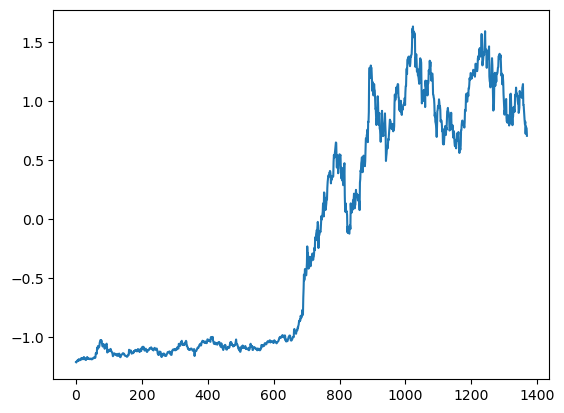

In [5]:
plt.plot(y_train)

## Develop an LSTM network

In [6]:
MAX_TIME = 50

In [7]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim):

        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers=1)

        self.linear1 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out = x
        # if len(x.shape)==2:
        #     out = x.view((-1, 1, self.input_dim))
        out,_ = self.lstm1(out)
        out = self.linear1(out)
        #out = self.linear2(out)
        out = out.view((-1, ))
        return out


class LinearPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim):

        super(LinearPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out = x
        # if len(x.shape)==2:
        #     out = x.view((-1, 1, self.input_dim))
        out = self.linear1(out)
        out = nn.ReLU()(out)
        out = self.linear2(out)
        out = out.view((-1, ))
        return out




 92%|█████████▏| 46/50 [00:50<00:04,  1.09s/it]


Text(0.5, 1.0, 'Train')

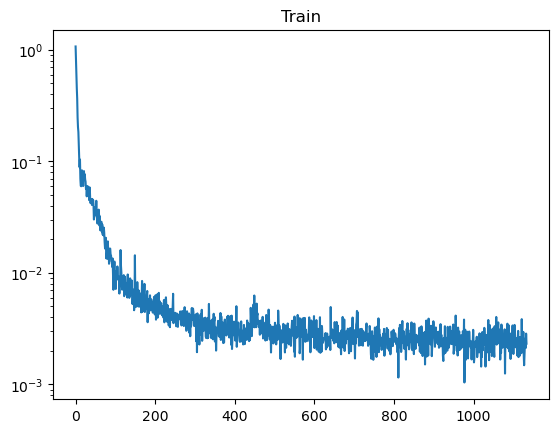

In [8]:
model = LSTMPredictor(x_train.shape[1], hidden_dim = 10)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)
EPOCHS = 10
BATCH_SIZE = 256
N = x_train.shape[0]
losses = []
t0 = time.time()
t1 = time.time()
with tqdm(total=MAX_TIME) as pbar:
    while time.time()<t0+MAX_TIME:
        if time.time()>t1+1:
            t1 = time.time()
            pbar.update()
        indices = np.arange(len(x_train))
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]
        #print(indices.shape)
        for i in range(N//BATCH_SIZE+1):
            model.zero_grad()
            batch_x = x_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            batch_y = y_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            output = model(batch_x)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()

            losses.append(loss.detach().numpy())
        scheduler.step

 
plt.semilogy(losses)
plt.title("Train")

tensor(194.2110, dtype=torch.float64)


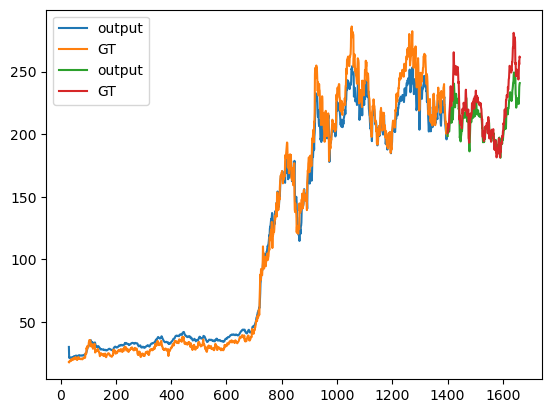

In [9]:
def test(model):
    with torch.no_grad():
        
        output = model(x_test)
        unscaled_output = scaler.inverse_transform(output.reshape((-1, 1))).reshape((-1, ))
        unscaled_y_test = scaler.inverse_transform(y_test.reshape((-1, 1))).reshape((-1,))

        output = model(x_train)

        unscaled_output_train = scaler.inverse_transform(output.reshape((-1, 1))).reshape((-1, ))
        unscaled_y_train = scaler.inverse_transform(y_train.reshape((-1, 1))).reshape((-1,))


        loss = loss_fn(torch.tensor(unscaled_output),torch.tensor(unscaled_y_test ))
        plt.figure()
        #print(unscaled_output_train.shape)
        plt.plot(np.arange(timesteps_count, split_index), unscaled_output_train, label="output")
        plt.plot(np.arange(timesteps_count, split_index), unscaled_y_train, label="GT")
        
        plt.plot(np.arange(split_index, split_index+len(x_test)), unscaled_output, label="output")
        plt.plot(np.arange(split_index, split_index+len(x_test)), unscaled_y_test, label="GT")
        plt.legend()
        print(loss)
x_train, y_train, x_test, y_test = get_train_test()

test(model)

## Predicting with moving average

In [10]:
window_size = 50
df["MA"] = df["Close"].rolling(window_size).mean()

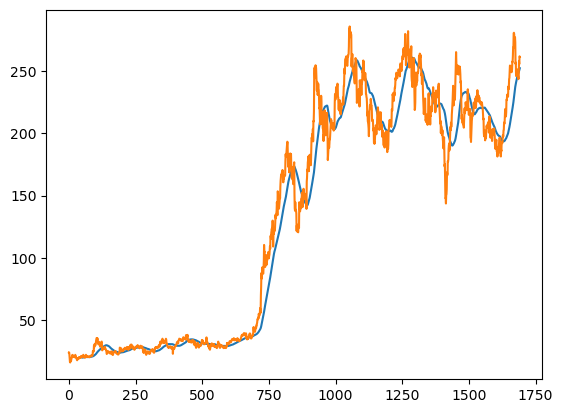

In [11]:
plt.plot(df["MA"])
plt.plot(df["Close"])

## Prediction with exponential average

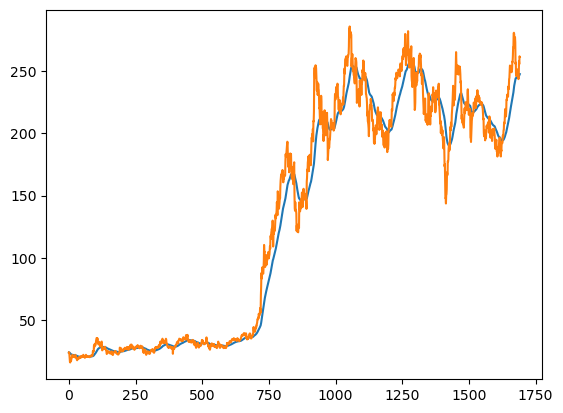

In [12]:
df["EA"] = df["Close"].ewm(span=window_size, adjust=False).mean()
plt.plot(df["EA"])
plt.plot(df["Close"])


In [13]:
%load_ext autoreload

%autoreload 2

from functions.PyTorchGN import NN_GN
from algorithms.algo2 import optimize

x_train, y_train, x_test, y_test = get_train_test()

y_train = y_train.reshape((-1, 1)).detach().numpy()
x_train = x_train.detach().numpy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


param 4
param 4
(1370, 30) (1370, 1) (1921,)
Parameter count 1921


  0%|          | 1/300 [00:00<01:26,  3.45it/s]

Train error:  0.9706514455976277
Epoch time:  0.28989171981811523


  1%|          | 2/300 [00:00<01:28,  3.37it/s]

Train error:  0.9564561829949818
Epoch time:  0.3004591464996338


  1%|          | 3/300 [00:00<01:28,  3.36it/s]

Train error:  0.8320234980896442
Epoch time:  0.29870080947875977


  1%|▏         | 4/300 [00:01<01:49,  2.70it/s]

Train error:  0.807999436872719
Epoch time:  0.4817240238189697


  2%|▏         | 5/300 [00:01<01:57,  2.50it/s]

Train error:  0.30680773658474
Epoch time:  0.45075058937072754


  2%|▏         | 6/300 [00:02<02:00,  2.45it/s]

Train error:  0.5788713218521898
Epoch time:  0.42409586906433105


  2%|▏         | 7/300 [00:02<01:52,  2.61it/s]

Train error:  0.5064377833456889
Epoch time:  0.32999587059020996


  3%|▎         | 8/300 [00:03<01:56,  2.51it/s]

Train error:  0.47975392585253196
Epoch time:  0.43245482444763184


  3%|▎         | 9/300 [00:03<01:59,  2.44it/s]

Train error:  0.4475440255046761
Epoch time:  0.43256425857543945


  3%|▎         | 10/300 [00:03<01:57,  2.46it/s]

Train error:  0.4234757249372719
Epoch time:  0.39720654487609863


  4%|▎         | 11/300 [00:04<02:04,  2.33it/s]

Train error:  0.3546932916571624
Epoch time:  0.4797046184539795


  4%|▍         | 12/300 [00:04<01:59,  2.42it/s]

Train error:  0.17313089858006386
Epoch time:  0.3762032985687256


  4%|▍         | 13/300 [00:05<02:02,  2.35it/s]

Train error:  0.020368663759997293
Epoch time:  0.4521028995513916


  5%|▍         | 14/300 [00:05<02:01,  2.36it/s]

Train error:  0.02029663420071567
Epoch time:  0.41808366775512695


  5%|▌         | 15/300 [00:05<01:52,  2.54it/s]

Train error:  0.0199318085273687
Epoch time:  0.3244640827178955


  5%|▌         | 16/300 [00:06<01:54,  2.49it/s]

Train error:  0.019931282266213077
Epoch time:  0.4174656867980957


  6%|▌         | 17/300 [00:06<01:56,  2.43it/s]

Train error:  0.019847583074639314
Epoch time:  0.4363079071044922


  6%|▌         | 18/300 [00:07<01:48,  2.61it/s]

Train error:  0.019353629898850935
Epoch time:  0.31501030921936035


  6%|▋         | 19/300 [00:07<01:49,  2.57it/s]

Train error:  0.01914040920508169
Epoch time:  0.4023706912994385


  7%|▋         | 20/300 [00:07<01:46,  2.62it/s]

Train error:  0.019038858900975137
Epoch time:  0.3609507083892822


  7%|▋         | 21/300 [00:08<01:42,  2.72it/s]

Train error:  0.01901225208366004
Epoch time:  0.33615732192993164


  7%|▋         | 22/300 [00:08<01:40,  2.76it/s]

Train error:  0.01851411944758283
Epoch time:  0.34598803520202637


  8%|▊         | 23/300 [00:08<01:37,  2.85it/s]

Train error:  0.018267481170431542
Epoch time:  0.32537055015563965


  8%|▊         | 24/300 [00:09<01:43,  2.67it/s]

Train error:  0.01810835538989436
Epoch time:  0.42656707763671875


  8%|▊         | 25/300 [00:09<01:37,  2.83it/s]

Train error:  0.017956410707348453
Epoch time:  0.30396151542663574


  9%|▊         | 26/300 [00:09<01:38,  2.78it/s]

Train error:  0.017878791363569943
Epoch time:  0.37169432640075684


  9%|▉         | 27/300 [00:10<01:41,  2.69it/s]

Train error:  0.017838767671237026
Epoch time:  0.40023064613342285


  9%|▉         | 28/300 [00:10<01:37,  2.79it/s]

Train error:  0.017784912220753023
Epoch time:  0.3265411853790283


 10%|▉         | 29/300 [00:11<01:46,  2.54it/s]

Train error:  0.017707718897910014
Epoch time:  0.4735138416290283


 10%|█         | 30/300 [00:11<01:44,  2.59it/s]

Train error:  0.017645377834347914
Epoch time:  0.3692314624786377


 10%|█         | 31/300 [00:11<01:39,  2.71it/s]

Train error:  0.017594504530412437
Epoch time:  0.32591986656188965


 11%|█         | 32/300 [00:12<01:44,  2.56it/s]

Max back track
Train error:  0.017594504530412437
Epoch time:  0.44160985946655273


 11%|█         | 33/300 [00:12<01:41,  2.64it/s]

Train error:  0.017214790399927293
Epoch time:  0.3513510227203369


 11%|█▏        | 34/300 [00:12<01:38,  2.70it/s]

Train error:  0.01706116808591968
Epoch time:  0.34744811058044434


 12%|█▏        | 35/300 [00:13<01:36,  2.74it/s]

Train error:  0.017004574128311047
Epoch time:  0.35459184646606445


 12%|█▏        | 36/300 [00:13<01:34,  2.80it/s]

Train error:  0.016946931825067006
Epoch time:  0.33834075927734375


 12%|█▏        | 37/300 [00:14<01:35,  2.76it/s]

Train error:  0.016943999798628536
Epoch time:  0.3706669807434082


 13%|█▎        | 38/300 [00:14<01:35,  2.76it/s]

Train error:  0.016921168696271242
Epoch time:  0.36301445960998535


 13%|█▎        | 39/300 [00:14<01:39,  2.62it/s]

Train error:  0.01691563320856025
Epoch time:  0.4238770008087158


 13%|█▎        | 40/300 [00:15<01:35,  2.73it/s]

Train error:  0.016623286783260152
Epoch time:  0.33063793182373047


 14%|█▎        | 41/300 [00:15<01:34,  2.75it/s]

Train error:  0.01608566785380788
Epoch time:  0.3565819263458252


 14%|█▍        | 42/300 [00:15<01:32,  2.79it/s]

Train error:  0.015993839458827555
Epoch time:  0.3441479206085205


 14%|█▍        | 43/300 [00:16<01:33,  2.76it/s]

Train error:  0.015993790730942776
Epoch time:  0.3731980323791504


 15%|█▍        | 44/300 [00:16<01:35,  2.69it/s]

Train error:  0.01586725555197166
Epoch time:  0.39046263694763184


 15%|█▌        | 45/300 [00:16<01:32,  2.77it/s]

Train error:  0.015800637572351162
Epoch time:  0.33516597747802734


 15%|█▌        | 46/300 [00:17<01:35,  2.65it/s]

Train error:  0.015533163251667998
Epoch time:  0.4164388179779053


 16%|█▌        | 47/300 [00:17<01:35,  2.64it/s]

Train error:  0.015407164079429459
Epoch time:  0.3785865306854248


 16%|█▌        | 48/300 [00:18<01:32,  2.72it/s]

Train error:  0.015302316985861228
Epoch time:  0.3423771858215332


 16%|█▋        | 49/300 [00:18<01:32,  2.72it/s]

Train error:  0.015155906398801038
Epoch time:  0.36553525924682617


 17%|█▋        | 50/300 [00:18<01:32,  2.70it/s]

Train error:  0.014841007316199532
Epoch time:  0.3774230480194092


 17%|█▋        | 51/300 [00:19<01:36,  2.58it/s]

Train error:  0.014837544851929603
Epoch time:  0.426433801651001


 17%|█▋        | 52/300 [00:19<01:36,  2.58it/s]

Train error:  0.014816071169219748
Epoch time:  0.3884909152984619


 18%|█▊        | 53/300 [00:20<01:37,  2.53it/s]

Max back track
Train error:  0.014816071169219748
Epoch time:  0.4126734733581543


 18%|█▊        | 54/300 [00:20<01:44,  2.34it/s]

Train error:  0.014703021084305143
Epoch time:  0.49667859077453613


 18%|█▊        | 55/300 [00:21<01:54,  2.14it/s]

Max back track
Train error:  0.014703021084305143
Epoch time:  0.5630161762237549


 19%|█▊        | 56/300 [00:21<01:44,  2.33it/s]

Train error:  0.014465675910894017
Epoch time:  0.33874964714050293


 19%|█▉        | 57/300 [00:21<01:37,  2.49it/s]

Train error:  0.01444205820125385
Epoch time:  0.33789920806884766


 19%|█▉        | 58/300 [00:22<01:31,  2.63it/s]

Train error:  0.01433369434662979
Epoch time:  0.32723522186279297


 20%|█▉        | 59/300 [00:22<01:36,  2.49it/s]

Train error:  0.014323117611181997
Epoch time:  0.4529991149902344


 20%|██        | 60/300 [00:23<01:42,  2.33it/s]

Train error:  0.014206269535705121
Epoch time:  0.48946499824523926


 20%|██        | 61/300 [00:23<01:50,  2.16it/s]

Train error:  0.014124292526802007
Epoch time:  0.5426812171936035


 21%|██        | 62/300 [00:24<01:50,  2.16it/s]

Train error:  0.014102225756123118
Epoch time:  0.463503360748291


 21%|██        | 63/300 [00:24<01:40,  2.35it/s]

Train error:  0.013750702795321054
Epoch time:  0.33205628395080566


 21%|██▏       | 64/300 [00:24<01:36,  2.44it/s]

Train error:  0.013612933750570256
Epoch time:  0.3771648406982422


 22%|██▏       | 65/300 [00:25<01:30,  2.58it/s]

Train error:  0.013554394854246265
Epoch time:  0.33150720596313477


 22%|██▏       | 66/300 [00:25<01:29,  2.62it/s]

Train error:  0.013552422071025319
Epoch time:  0.3668057918548584


 22%|██▏       | 67/300 [00:25<01:25,  2.74it/s]

Train error:  0.013463009186904795
Epoch time:  0.32754945755004883


 23%|██▎       | 68/300 [00:26<01:25,  2.72it/s]

Train error:  0.013419322549861713
Epoch time:  0.372605562210083


 23%|██▎       | 69/300 [00:26<01:22,  2.80it/s]

Train error:  0.013369769075491133
Epoch time:  0.3323845863342285


 23%|██▎       | 70/300 [00:26<01:20,  2.86it/s]

Train error:  0.013298359056458856
Epoch time:  0.33168745040893555


 24%|██▎       | 71/300 [00:27<01:19,  2.87it/s]

Train error:  0.013284293404460823
Epoch time:  0.34270358085632324


 24%|██▍       | 72/300 [00:27<01:18,  2.90it/s]

Train error:  0.013154929223721915
Epoch time:  0.33611249923706055


 24%|██▍       | 73/300 [00:27<01:16,  2.97it/s]

Train error:  0.012918928939930715
Epoch time:  0.31743311882019043


 25%|██▍       | 74/300 [00:28<01:15,  2.99it/s]

Train error:  0.012901482964954237
Epoch time:  0.32662463188171387


 25%|██▌       | 75/300 [00:28<01:13,  3.06it/s]

Train error:  0.012649356535751454
Epoch time:  0.30861926078796387


 25%|██▌       | 76/300 [00:28<01:12,  3.08it/s]

Train error:  0.012593443376304459
Epoch time:  0.31919097900390625


 26%|██▌       | 77/300 [00:29<01:14,  3.01it/s]

Train error:  0.01251036511720532
Epoch time:  0.3488173484802246


 26%|██▌       | 78/300 [00:29<01:13,  3.03it/s]

Train error:  0.012350628149770473
Epoch time:  0.32492709159851074


 26%|██▋       | 79/300 [00:29<01:15,  2.91it/s]

Train error:  0.012313171720852818
Epoch time:  0.37271642684936523


 27%|██▋       | 80/300 [00:30<01:17,  2.82it/s]

Train error:  0.012282300517506842
Epoch time:  0.37892961502075195


 27%|██▋       | 81/300 [00:30<01:20,  2.71it/s]

Train error:  0.01226227753353815
Epoch time:  0.40271496772766113


 27%|██▋       | 82/300 [00:31<01:18,  2.77it/s]

Train error:  0.012261105279852875
Epoch time:  0.3403182029724121


 28%|██▊       | 83/300 [00:31<01:16,  2.83it/s]

Train error:  0.012258251218030052
Epoch time:  0.33511924743652344


 28%|██▊       | 84/300 [00:31<01:18,  2.76it/s]

Train error:  0.012164154888069543
Epoch time:  0.3809394836425781


 28%|██▊       | 85/300 [00:32<01:15,  2.83it/s]

Train error:  0.012038278231655593
Epoch time:  0.33117127418518066


 29%|██▊       | 86/300 [00:32<01:14,  2.87it/s]

Train error:  0.011960864937218436
Epoch time:  0.33827829360961914


 29%|██▉       | 87/300 [00:32<01:14,  2.87it/s]

Train error:  0.011860350448719777
Epoch time:  0.34685754776000977


 29%|██▉       | 88/300 [00:33<01:14,  2.86it/s]

Train error:  0.01183716432891623
Epoch time:  0.3529632091522217


 30%|██▉       | 89/300 [00:33<01:13,  2.89it/s]

Train error:  0.011823423065408303
Epoch time:  0.3365941047668457


 30%|███       | 90/300 [00:33<01:12,  2.88it/s]

Train error:  0.011777430903302492
Epoch time:  0.34776949882507324


 30%|███       | 91/300 [00:34<01:12,  2.90it/s]

Train error:  0.011754578917566007
Epoch time:  0.33805036544799805


 31%|███       | 92/300 [00:34<01:10,  2.96it/s]

Train error:  0.01150302190850251
Epoch time:  0.3224184513092041


 31%|███       | 93/300 [00:34<01:10,  2.94it/s]

Train error:  0.011484633397011862
Epoch time:  0.3450174331665039


 31%|███▏      | 94/300 [00:35<01:09,  2.96it/s]

Train error:  0.01141277577755225
Epoch time:  0.33150458335876465


 32%|███▏      | 95/300 [00:35<01:08,  2.99it/s]

Train error:  0.01109994902227917
Epoch time:  0.32637977600097656


 32%|███▏      | 96/300 [00:35<01:08,  2.96it/s]

Train error:  0.011065643199168853
Epoch time:  0.3426370620727539


 32%|███▏      | 97/300 [00:36<01:08,  2.94it/s]

Train error:  0.010997846004736685
Epoch time:  0.34374070167541504


 33%|███▎      | 98/300 [00:36<01:09,  2.89it/s]

Train error:  0.010891541947413534
Epoch time:  0.36156368255615234


 33%|███▎      | 99/300 [00:36<01:11,  2.80it/s]

Train error:  0.0108691974277914
Epoch time:  0.38222718238830566


 33%|███▎      | 100/300 [00:37<01:12,  2.75it/s]

Train error:  0.010865356974358106
Epoch time:  0.3763875961303711


 34%|███▎      | 101/300 [00:37<01:16,  2.58it/s]

Train error:  0.010830144812590885
Epoch time:  0.44050168991088867


 34%|███▍      | 102/300 [00:38<01:18,  2.53it/s]

Train error:  0.010820889995045905
Epoch time:  0.4136471748352051


 34%|███▍      | 103/300 [00:38<01:18,  2.51it/s]

Train error:  0.010735032854289034
Epoch time:  0.4025087356567383


 35%|███▍      | 104/300 [00:38<01:20,  2.44it/s]

Train error:  0.010700802211343808
Epoch time:  0.434859037399292


 35%|███▌      | 105/300 [00:39<01:17,  2.50it/s]

Train error:  0.010660234158926637
Epoch time:  0.3766493797302246


 35%|███▌      | 106/300 [00:39<01:18,  2.46it/s]

Train error:  0.010597379364236428
Epoch time:  0.4229881763458252


 36%|███▌      | 107/300 [00:40<01:14,  2.59it/s]

Train error:  0.01046813421875891
Epoch time:  0.33567380905151367


 36%|███▌      | 108/300 [00:40<01:12,  2.65it/s]

Train error:  0.010412956154259452
Epoch time:  0.3569159507751465


 36%|███▋      | 109/300 [00:40<01:12,  2.64it/s]

Train error:  0.010412264914408217
Epoch time:  0.3820011615753174


 37%|███▋      | 110/300 [00:41<01:11,  2.66it/s]

Train error:  0.010350342910655223
Epoch time:  0.3664398193359375


 37%|███▋      | 111/300 [00:41<01:07,  2.79it/s]

Train error:  0.010172920505495836
Epoch time:  0.3180727958679199


 37%|███▋      | 112/300 [00:41<01:05,  2.87it/s]

Train error:  0.010133128618671947
Epoch time:  0.3249232769012451


 38%|███▊      | 113/300 [00:42<01:04,  2.90it/s]

Train error:  0.009992573035024379
Epoch time:  0.3350362777709961


 38%|███▊      | 114/300 [00:42<01:03,  2.94it/s]

Train error:  0.009872916145046262
Epoch time:  0.3296327590942383


 38%|███▊      | 115/300 [00:42<01:09,  2.68it/s]

Train error:  0.009751390192630518
Epoch time:  0.4502232074737549


 39%|███▊      | 116/300 [00:43<01:17,  2.36it/s]

Max back track
Train error:  0.009751390192630518
Epoch time:  0.5386457443237305


 39%|███▉      | 117/300 [00:43<01:12,  2.53it/s]

Train error:  0.009730317470801138
Epoch time:  0.32843017578125


 39%|███▉      | 118/300 [00:44<01:11,  2.53it/s]

Train error:  0.00969252969226698
Epoch time:  0.3925321102142334


 40%|███▉      | 119/300 [00:44<01:07,  2.67it/s]

Train error:  0.00956801393606367
Epoch time:  0.324552059173584


 40%|████      | 120/300 [00:44<01:05,  2.75it/s]

Train error:  0.009492689675658288
Epoch time:  0.3407626152038574


 40%|████      | 121/300 [00:45<01:03,  2.83it/s]

Train error:  0.009432760642392792
Epoch time:  0.3283374309539795


 41%|████      | 122/300 [00:45<01:03,  2.80it/s]

Train error:  0.009423117393994854
Epoch time:  0.3660008907318115


 41%|████      | 123/300 [00:45<01:02,  2.82it/s]

Train error:  0.009317870035658787
Epoch time:  0.3451411724090576


 41%|████▏     | 124/300 [00:46<01:01,  2.86it/s]

Train error:  0.00924501001399799
Epoch time:  0.3375091552734375


 42%|████▏     | 125/300 [00:46<01:05,  2.69it/s]

Max back track
Train error:  0.00924501001399799
Epoch time:  0.4232814311981201


 42%|████▏     | 126/300 [00:47<01:02,  2.80it/s]

Train error:  0.00912139154698727
Epoch time:  0.32176923751831055


 42%|████▏     | 127/300 [00:47<01:00,  2.88it/s]

Train error:  0.009041154123570797
Epoch time:  0.3244175910949707


 43%|████▎     | 128/300 [00:47<01:00,  2.82it/s]

Train error:  0.008966658933319315
Epoch time:  0.3686246871948242


 43%|████▎     | 129/300 [00:48<00:59,  2.85it/s]

Train error:  0.008936461567008582
Epoch time:  0.3412587642669678


 43%|████▎     | 130/300 [00:48<00:58,  2.93it/s]

Train error:  0.008774345982683836
Epoch time:  0.3184199333190918


 44%|████▎     | 131/300 [00:48<00:57,  2.94it/s]

Train error:  0.008658113270780466
Epoch time:  0.3366532325744629


 44%|████▍     | 132/300 [00:49<00:56,  2.96it/s]

Train error:  0.008653608725888886
Epoch time:  0.3331761360168457


 44%|████▍     | 133/300 [00:49<00:56,  2.98it/s]

Train error:  0.008624721443566092
Epoch time:  0.3293731212615967


 45%|████▍     | 134/300 [00:49<00:55,  2.98it/s]

Train error:  0.008558017145978274
Epoch time:  0.33528852462768555


 45%|████▌     | 135/300 [00:50<01:01,  2.70it/s]

Train error:  0.008359455192176094
Epoch time:  0.3291168212890625
timeout


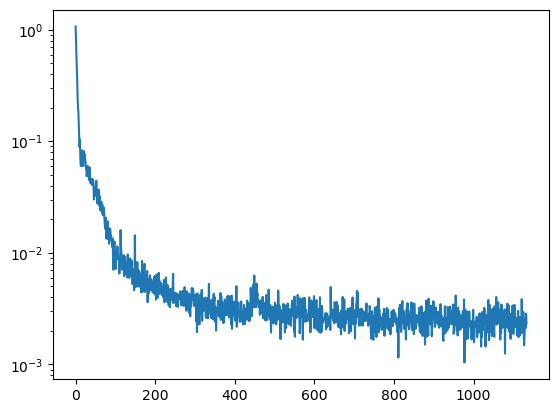

In [14]:
input_dim, hidden_dim = x_train.shape[1], 10
model = LSTMPredictor(input_dim, hidden_dim)

input_dim, hidden_dim = x_train.shape[1], 60

model = LinearPredictor(input_dim, hidden_dim)
nn_gn = NN_GN(model, is_linear=False)
X0 = nn_gn.get_X()


print(x_train.shape, y_train.shape, X0.shape)
## Do Gauss Newton

X_est,losses_gn_backtrack, _ = optimize(nn_gn, X0, x_train, y_train, steps=300,batch_size=300 ,
max_time=MAX_TIME,backtrack=True,optimization_method="Random", lambd=0.001)
plt.semilogy(losses)

tensor(148.4499, dtype=torch.float64)


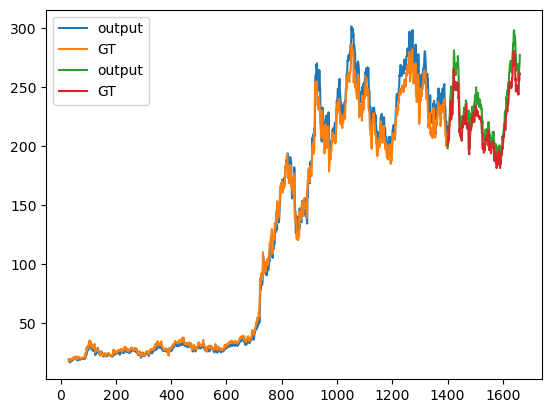

In [15]:
x_train, y_train, x_test, y_test = get_train_test()


test(model)

In [16]:
model(x_train)

tensor([-1.1984, -1.2119, -1.2229,  ...,  0.8904,  0.8413,  0.8927],
       grad_fn=<ViewBackward0>)